In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt
from math import sqrt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
dataset_root_dir = '/datasets/ee285f-public/bsds/'

In [4]:
class NoisyBSDSDataset(td.Dataset): # inheriting from td.Dataset parent class
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode) # in the root directory there are directories corresponding to mode
        self.files = os.listdir(self.images_dir) # list of all names of entries in images_dir is stored in files
    def __len__(self):
        return len(self.files) # returns number of files
    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma) # returns info about the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx]) # stores path of image with idx in img_path
        clean = Image.open(img_path).convert('RGB') # opens image at img_path and stores in clean
        i = np.random.randint(clean.size[0] - self.image_size[0]) # returns an integer between 0 and size difference vert
        j = np.random.randint(clean.size[1] - self.image_size[1]) # returns an integer between 0 and size difference hor
        # COMPLETE
        clean = clean.crop([i, j, i+180, j+180])
        clean = np.asarray(clean)
        transform = tv.transforms.Compose([
            tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
        ])
        clean = transform(clean)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape) 
        return noisy, clean

In [5]:
train_set = NoisyBSDSDataset(dataset_root_dir, mode="train", image_size=(180, 180), sigma=30)
test_set = NoisyBSDSDataset(dataset_root_dir, mode="test", image_size=(320, 320), sigma=30)
x = test_set.__getitem__(12)

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


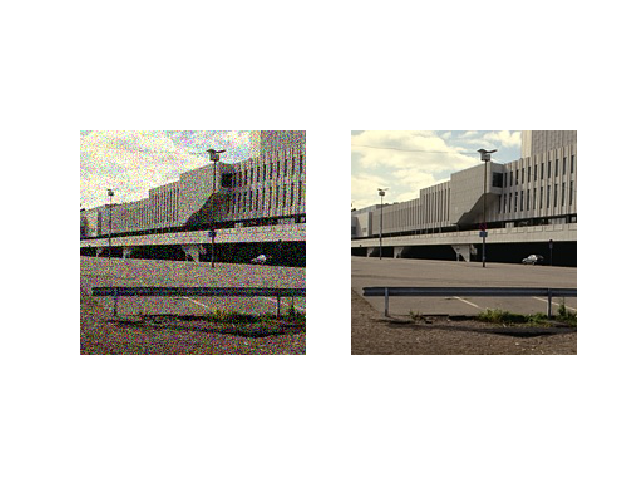

To the left is the noisy image and to the right is the clean image


In [7]:
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
myimshow(x[1], ax=axes[1])
print('To the left is the noisy image and to the right is the clean image')

In [8]:
class NNRegressor(nt.NeuralNetwork): # inherits attributes from nt.NeuralNetwork and defines loss in method 'criterion'
    
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.mse(y, d)


In [9]:
class DnCNN(NNRegressor): # inherits attributes from NNRegressor
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__() # inherits all properties of parent classes
        self.D = D  # sets attribute of class D to value D passed to function
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        for i in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        # COMPLETE
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        y = self.conv[D+1](h) + x
        return y


In [10]:
class DenoisingStatsManager(nt.StatsManager):
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0
        
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        n = torch.numel(y)
        temppsnr = 0
        self.batch_size = len(y)
        for i in range(self.batch_size):
            temppsnr = temppsnr + 10*torch.log10((4)/(((y[i]-d[i])**2).mean()))
        temppsnr = temppsnr/self.batch_size
        self.running_psnr += temppsnr
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'psnr': psnr}

In [11]:
net = DnCNN(6,64)

In [12]:
net = net.to(device)

In [13]:
lr = 1e-3
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size = 4, output_dir="denoising1", perform_validation_during_training=True)

In [14]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised Image')
    l1 = []
    l2 = []
    for k in range(exp.epoch):
        l1.append(exp.history[k][0]['loss'])
        l2.append(exp.history[k][0]['psnr'])
    #print('Shape of l2 is', l2[0].shape)
    axes[1][0].plot(l1,label = 'training loss')
    axes[1][0].legend()
    axes[1][0].set(xlabel = 'Epoch', ylabel = 'Loss')       
#     print(len(l1))
#     print(len(l2))
    axes[1][1].plot(l2,label = 'training PSNR')
#    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="training PSNR")
    axes[1][1].legend()
    axes[1][1].set(xlabel = 'Epoch', ylabel = 'PSNR')
    # COMPLETE
    plt.tight_layout()
    fig.canvas.draw()


<IPython.core.display.Javascript object>


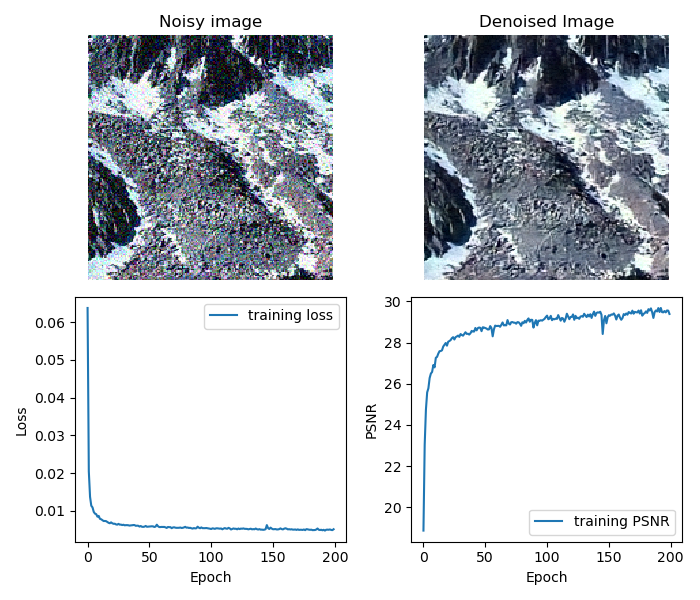

Start/Continue training from epoch 200
Finish training for 200 epochs


In [15]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

In [16]:
im1 = test_set.__getitem__(1)
im2 = test_set.__getitem__(27)
im3 = test_set.__getitem__(56)
with torch.no_grad():
    denoised1 = exp1.net(im1[0][np.newaxis].to(exp1.net.device))[0]
    denoised2 = exp1.net(im2[0][np.newaxis].to(exp1.net.device))[0]
    denoised3 = exp1.net(im3[0][np.newaxis].to(exp1.net.device))[0]

<IPython.core.display.Javascript object>


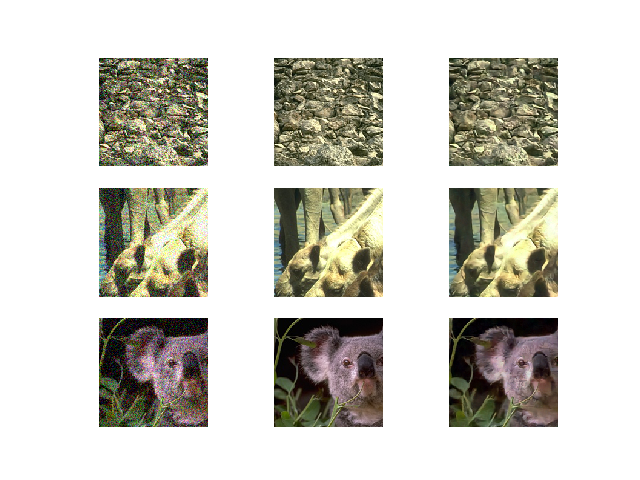

Column 1: Noisy Images; Column 2: Clean Images; Column 3: Denoised Images


In [17]:
fig2, axes2 = plt.subplots(ncols=3, nrows = 3,sharex = 'all',sharey = 'all')
myimshow(im1[0], axes2[0,0])
myimshow(im1[1], axes2[0,1])
myimshow(denoised1, axes2[0,2])
myimshow(im2[0], axes2[1,0])
myimshow(im2[1], axes2[1,1])
myimshow(denoised2, axes2[1,2])
myimshow(im3[0], axes2[2,0])
myimshow(im3[1], axes2[2,1])
myimshow(denoised3, axes2[2,2])
print('Column 1: Noisy Images; Column 2: Clean Images; Column 3: Denoised Images')

There is loss of information in the denoised image. It is less detailed than the clean image. 

DnCNN(D) has (3523 + 37056D) parameters.

In [18]:
class UDnCNN(NNRegressor): # inherits attributes from NNRegressor
    
    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__() # inherits all properties of parent classes
        self.D = D  # sets attribute of class D to value D passed to function
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        for i in range(D):
            self.conv.append(nn.Conv2d(C, C, 3, padding=1))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        tensorDimList = []
        tensorList = []
        maxpoolindicesList = []
        h = F.relu(self.conv[0](x))
        tensorList.append(h)
        # COMPLETE
        for i in range(D):
            if(i<((D)/2)-1):
                h = F.relu(self.bn[i](self.conv[i+1](h)))
                tensorDimList.append(h.size())
                h,indices = F.max_pool2d(h, kernel_size = (2,2), return_indices=True)
                tensorList.append(h)
                maxpoolindicesList.append(indices)
            elif(i == D/2 - 1):
                h = F.relu(self.bn[i](self.conv[i+1](h)))
            elif(i == (D/2)):
                h = (F.relu(self.bn[i](self.conv[i+1](h))) + tensorList[D-i-1])/sqrt(2)
            else:
                h = F.max_unpool2d(h,maxpoolindicesList[D-i-1],kernel_size = (2,2), output_size=tensorDimList[D-i-1])
                h = (F.relu(self.bn[i](self.conv[i+1](h))) + tensorList[D-i-1])/sqrt(2)
        y = self.conv[D+1](h) + x
        return y


In [19]:
net2 = UDnCNN(6,64)

In [20]:
net2 = net2.to(device)

In [21]:
lr = 1e-3
adam2 = torch.optim.Adam(net2.parameters(), lr=lr)
stats_manager2 = DenoisingStatsManager()
exp2 = nt.Experiment(net2, train_set, test_set, adam2, stats_manager2, batch_size = 4, output_dir="denoising2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


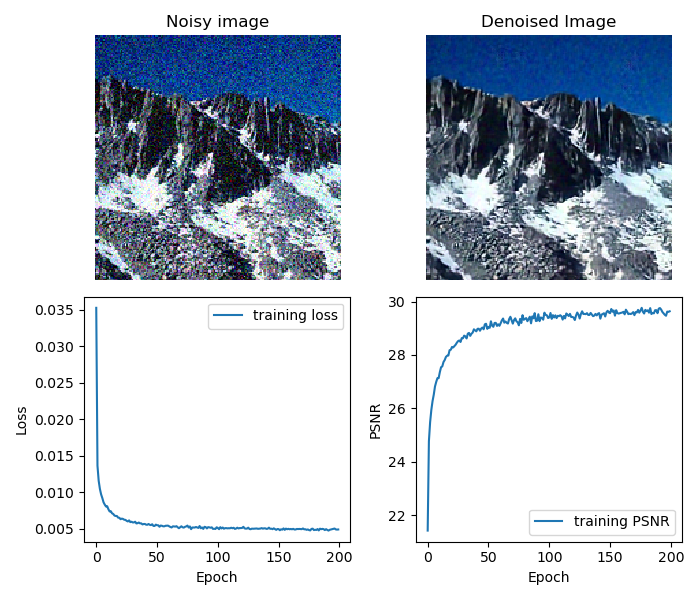

Start/Continue training from epoch 200
Finish training for 200 epochs


In [22]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

In [23]:
class DUDnCNN(NNRegressor): # inherits attributes from NNRegressor
    
    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__() # inherits all properties of parent classes
        self.D = D  # sets attribute of class D to value D passed to function
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        num_pool = 0
        num_unpool = 0
        for i in range(D):
            if(i<D/2 - 1):
                self.conv.append(nn.Conv2d(C,C,3,padding=2**(i+1), dilation = 2**(i+1)))
            elif(i==D/2 - 1):
                num_pool = i
                self.conv.append(nn.Conv2d(C,C,3,padding=2**(i), dilation = 2**(i)))
            elif(i == D/2):
                self.conv.append(nn.Conv2d(C,C,3,padding=2**(num_pool), dilation = 2**(num_pool)))
            else:
                self.conv.append(nn.Conv2d(C,C,3,padding=2**(num_pool - int(i - D/2)), dilation = 2**(num_pool - int(i - (D/2)))))
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))
            
    def forward(self, x):
        D = self.D
        tensorDimList = []
        tensorList = []
        maxpoolindicesList = []
        h = F.relu(self.conv[0](x))
        tensorList.append(h)
        # COMPLETE
        for i in range(D):
            if(i<((D)/2)-1):
                h = F.relu(self.bn[i](self.conv[i+1](h)))
                tensorList.append(h)
            elif(i == D/2 - 1):
                h = F.relu(self.bn[i](self.conv[i+1](h)))
            elif(i >= (D/2)):
                h = (F.relu(self.bn[i](self.conv[i+1](h))) + tensorList[D-i-1])/sqrt(2)
            
        y = self.conv[D+1](h) + x
        return y


In [24]:
net3 = DUDnCNN(6,64)

In [25]:
net3 = net3.to(device)

In [30]:
torch.backends.cudnn.benchmark=True

In [26]:
lr = 1e-3
adam3 = torch.optim.Adam(net3.parameters(), lr=lr)
stats_manager3 = DenoisingStatsManager()
exp3 = nt.Experiment(net3, train_set, test_set, adam3, stats_manager3, batch_size = 4, output_dir="denoising3", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


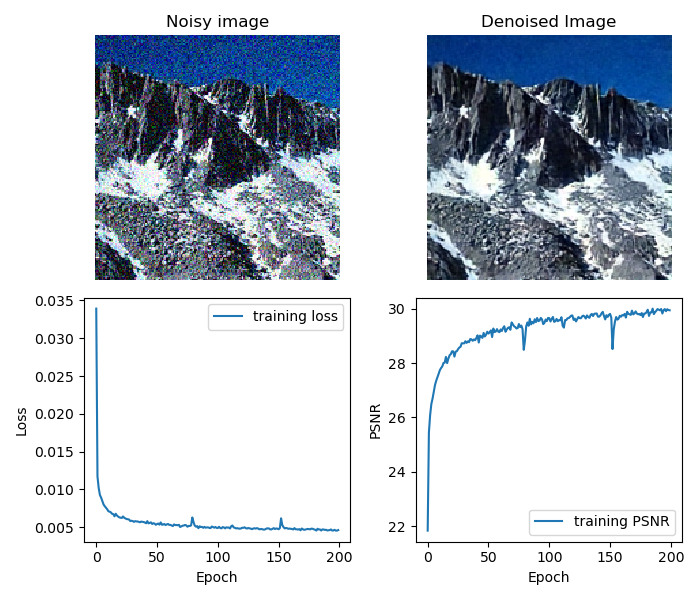

Start/Continue training from epoch 200
Finish training for 200 epochs


In [27]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=test_set[73][0]))

In [32]:
torch.backends.cudnn.benchmark=False # Question 17

In [33]:
print('The loss and PSNR for DnCNN are',exp1.evaluate())
print('The loss and PSNR for UDnCNN are: ', exp2.evaluate())
print('The loss and PSNR for DUDnCNN are: ', exp3.evaluate())

The loss and accuracy for DnCNN are {'loss': 0.004832217684015632, 'psnr': tensor(29.7303, device='cuda:0')}
The loss and accuracy for UDnCNN are:  {'loss': 0.004707091962918639, 'psnr': tensor(29.9239, device='cuda:0')}
The loss and accuracy for DUDnCNN are:  {'loss': 0.0051162866968661545, 'psnr': tensor(29.6369, device='cuda:0')}


<IPython.core.display.Javascript object>


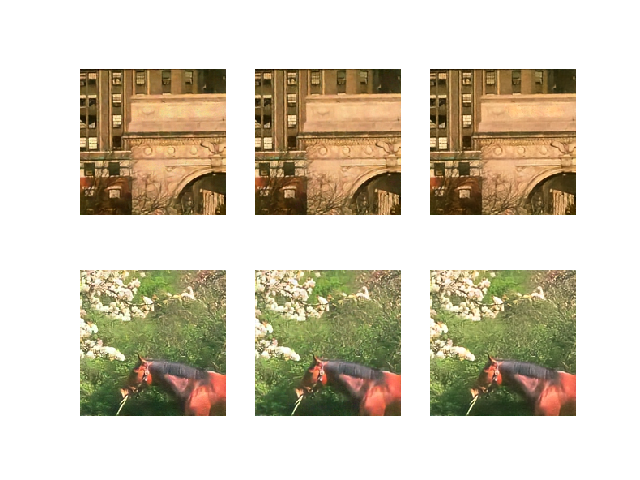

Columns from left to right: Output of DnCNN, Output of UDnCNN, Output of DUDnCNN


In [38]:
imcomp1 = test_set.__getitem__(67)
imcomp2 = test_set.__getitem__(20)
with torch.no_grad():
    denoisedimcomp1_net1 = exp1.net(imcomp1[0][np.newaxis].to(exp1.net.device))[0]
    denoisedimcomp1_net2 = exp2.net(imcomp1[0][np.newaxis].to(exp2.net.device))[0]
    denoisedimcomp1_net3 = exp3.net(imcomp1[0][np.newaxis].to(exp3.net.device))[0]
    denoisedimcomp2_net1 = exp1.net(imcomp2[0][np.newaxis].to(exp1.net.device))[0]
    denoisedimcomp2_net2 = exp2.net(imcomp2[0][np.newaxis].to(exp2.net.device))[0]
    denoisedimcomp2_net3 = exp3.net(imcomp2[0][np.newaxis].to(exp3.net.device))[0]
fig3, axes3 = plt.subplots(ncols=3, nrows = 2,sharex = 'all',sharey = 'all')
myimshow(denoisedimcomp1_net1, axes3[0,0])
myimshow(denoisedimcomp1_net2, axes3[0,1])
myimshow(denoisedimcomp1_net3, axes3[0,2])
myimshow(denoisedimcomp2_net1, axes3[1,0])
myimshow(denoisedimcomp2_net2, axes3[1,1])
myimshow(denoisedimcomp2_net3, axes3[1,2])
print("Columns from left to right: Output of DnCNN, Output of UDnCNN, Output of DUDnCNN")